# Выявление факторов, определяющих успешность видеоигр

В нашем распоряжении данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Цели исследования:**
- Проанализировать основные показатели, построить графики, определить основные тенденции.
- Сравнить портреты пользователей разных регионов.
- Проверить некоторые статистические гипотезы.

**Описание данных:**
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — возрастной рейтинг от организации ESRB.

**Основные этапы работ:**
1. Изучение и предобработка данных.
2. Построение графиков по основным показателям.
3. Выделение актуальных платформ.
4. Сравнение продаж игр для различных платформ.
5. Определение степени влияния оценок на продажи.
6. Определение наиболее прибыльных жанров.
7. Сравнение поведения пользователей из различных регионов.
8. Проверка гипотез.
9. Резюмирование результатов.

## Общая информация о данных

In [1]:
from scipy import stats as st
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('/datasets/games.csv')

Вывод первых строк таблицы

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Основная информация о датафрейме

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Количество пропусков в каждой колонке, а так же их процент.

In [5]:
# Вывод общего количества строк
print('Всего строк:', data.shape[0])
# Таблица с пропусками в данных
pd.DataFrame({'percent': (data.isna().mean()*100).round(2), 'sum': data.isna().sum()}).style.background_gradient('coolwarm')

Всего строк: 16715


,percent,sum
Name,0.010000,2
Platform,0.000000,0
Year_of_Release,1.610000,269
Genre,0.010000,2
NA_sales,0.000000,0
EU_sales,0.000000,0
JP_sales,0.000000,0
Other_sales,0.000000,0
Critic_Score,51.320000,8578
User_Score,40.090000,6701


**Вывод:** для дальнейшей работы с данными необходимо выполнить следующее:
1. привести к нижнему регистру названия столбцов
2. по возможности заполнить пропуски в колонках: год релиза (**1.6%** пропусков), оценки от критиков и пользователей(**51%** и **40%** пропусков), возрастной рейтинг (**40%** пропусков). Так разобраться с двумя пустыми значениями в колонках Name и Genre.
3. Тип данных в столбце User_Score преобразовать во `float`.

## Предобработка данных

Приведем названия столбцов к нижнему регистру

In [6]:
data.columns = data.columns.str.lower()
# Проверяем результат
data.head(0)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Проверим пропуски в столбцах `genre` и `name`

In [7]:
data.query('name.isna() or genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Здесь не дастья установить названия игр, поэтому удалим данные строки

In [8]:
data.dropna(subset=['name'], inplace=True)

### Заполнение пропусков столбца `year_of_release` (год релиза)

Некоторые игры выходят сразу на несколько платформ. Это значит, что одной и той же игры, к примеру, может быть пропущена дата релиза на XBox 360, но для PlayStation 3 она указана. Найдем такие игры, и заполним пропуски. Могут быть исключения, когда игры выходят с большими перерывами на разные платформы, поэтому в наш алгоритм добавим такое условие, что бы разница между самым ранним и самым поздним выходом одной и той же игры на разные платформы была максимум 1 год.

In [9]:
isna_before = data['year_of_release'].isna().sum()

def year_find(name):
    # для данной игры найдем уникальные даты релиза на других платформах и сложим их в массив
    year = data.loc[data['name'] == name, 'year_of_release'].unique()
    # из массива с датами удалим пропуски
    year = year[~np.isnan(year)]
    # если в массиве всего одна дата или (дат больше одной и разница между ними не превышает 2-х лет)
    try:
        if year.shape[0] == 1 or (year.shape[0] > 1 and year.max() - year.min() < 2):
            # присвоим для данной строки единственную или минимальную дату из массива
            return year.min()
    except:
        pass

data['year_of_release'].fillna(data['name'].apply(year_find), inplace=True)

print('Количество заполненных пропусков:', isna_before - data['year_of_release'].isna().sum())

Количество заполненных пропусков: 118


В названиях некоторых игр уже содержится год выпуска (или ему предшествующий). Для нас не так уж важна идеальная точность, поэтому везде примем год в названии за год выхода.

In [10]:
isna_before = data['year_of_release'].isna().sum()

# Функция для извлечения года из названия игры
def year_in_name(name):
    try:
        # если в названии игры есть последовательность из 4 цифр
        if re.search(r'\d{4}', name):
            year_find = int(re.search(r'\d{4}', name).group(0))
            # условие - если последовательность из четырех чисел лежит в промежутке от 1970 до 2017
            if 1970 < year_find < 2017:
                return year_find
    except:
        pass

# Применим функцию к стобцу 'year_of_release'
data['year_of_release'].fillna(data['name'].apply(year_in_name), inplace=True)

print('Количество заполненных пропусков:', isna_before - data['year_of_release'].isna().sum())

Количество заполненных пропусков: 7


**Вывод:** в столбце `year_of_release` нам удалось избавиться от **125** пропусков, взяв даты релизов из одноименных игр для других платформ, а так же, в ряде случаев, узнав дату из самого названия.

Пропуски в дате релиза могли образоваться по нескольким вероятным причинам:
- отсутствие данного показателя у очень старых игр
- человеческий фактор (забыли указать)
- потеря при выгрузке данных

### Стобец `user_score` (оценка пользователей)

Рассмотри подробнее уникальные значения столбца

In [11]:
print(data['user_score'].value_counts())

isna_before = data['user_score'].isna().sum()
tbd_before = data.query('user_score == "tbd"').shape[0]

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1         2
0.6       2
1.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64


Во многих строках присутствует текстовое значение - tbd (To Be Determined - будет определено). В нашем случае это означает, что пользовательский рейтинг еще не сформирован, поэтому приравняем подобные значения к `NaN`.

In [12]:
data['user_score'].replace('tbd', np.nan, inplace=True)

print('Количество новых пропусков:', abs(isna_before - data['user_score'].isna().sum()))
print('Количество удаленных значений "tbd":', abs(tbd_before - data.query('user_score == "tbd"').shape[0]))

Количество новых пропусков: 2424
Количество удаленных значений "tbd": 2424


**Промежуточный вывод:** замена строкового значения tbd на пустую строку произведено успешно.

Преобразуем тип данных во `float`

In [13]:
data['user_score'] = data['user_score'].astype(float)

Домножим каждое значение столбца на 10, что бы рейтинг был по 100-бальной шкале, по аналогии с колонкой `critic_score`, для единообразия

In [14]:
data['user_score'] *= 10

# Удостоверимся в успешности изменений
display(data.head())
data.info()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16569 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


**Вывод:** мы избавились от "заглушек" в виде значения 'tbd', преобразовали тип столбца в числовой и привели рейтинг к сто-бальной шкале.<br>
Какого либо адекватного способа заполнить пропуски в этих данных у нас нет. Среднее и медиана не подойдут, так как на рейтинг игры влияет слишком много параметров, которых у нас нет возможности учесть (специфика и успешность рекламной компании, манипуляция общественным мнением), а так же то, что этот показатель очень субъективен (разработчик или игровая серия могут быть переоценены за прошлые удачные релизы, либо же наоборот).<br>
Взять рейтинг для одноименных игр с других платформ (как мы это делали с годом выпуска) так же плохая идея. Так как одна и та же игра может существенно отличаться в своей реализации на разных платформах. Их даже могут производить разные студии.

Пропуски в этих данных могли образоваться по следующим причинам:
- отсутствие достаточного количества голосов для формирования оценки (для старых, редких и недавно вышедших игр)
- человеческий фактор
- сбой при выгрузке данных

### Стобец `critic_score` (оценка критиков)

**Вывод:** как и столбец с пользовательским рейтингом, пропуски в оценке критиков мы так же не сможем адекватно восстановить, по схожим причинам.<br>
Возможные причины пропусков так же совпадают с теми, что перечислены в предыдущем пункте.

### Столбец `rating` (возрастной рейтинг ESRB)

Информация по данному рейтингу из wiki:
- `EC` («Early childhood») — Для детей младшего возраста
- `E` («Everyone») — Для всех. Первоначально "K-A" ("Kids to Adults"):
- `E10+` («Everyone 10 and older») — Для всех от 10 лет и старше
- `T` («Teen») — Подросткам (для лиц от 13 лет)
- `M` («Mature») — Для взрослых (для лиц от 17 лет)
- `AO` («Adults Only 18+») — Только для взрослых (для лиц от 18 лет)
- `RP` («Rating Pending») — Рейтинг ожидается: продукт был отправлен в ESRB и ожидает присвоения рейтинга

Рассмотрим уникальные значения столбца

In [15]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

`K-A` переименуем `E`, потому, что это старое и новое название одного и того же рейтинга.<br>
`RP` фактически означает отсутствие рейтинга у игры, поэтому заменим данное значение на `NaN`

In [16]:
data['rating'].replace('K-A', 'E', inplace=True)
data['rating'].replace('RP', np.nan, inplace=True)

# Проверим результат
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC'], dtype=object)

**Промежуточный вывод:** замена значений произведена успешно

Заполним часть пропусков по аналогии с годом выпуска. Применим следующую логику: если на одноименной игре на других платформах рейтинг указан минимум у двух релизов, и совпадает между собой, то в таком случае воспользуемся данным значением для заполнения пропуска.

In [17]:
isna_before = data['rating'].isna().sum()

def year_find(name):
    # для данной игры найдем уникальные значения возрастного рейтинга на других платформах и сложим их в массив
    # удалим пропуски NaN
    rate = data.loc[data['name'] == name, 'rating'].dropna().reset_index(drop=True)
    rate_count = rate.shape[0]
    rate_unique = rate.unique().shape[0]
    try:
        # если возрастной рейтинг у одноименных игр на других платформах указан 2 и более раза
        # а так же совпадает между собой
        if rate_count > 1 and rate_unique == 1:
            return rate[0]
    except:
        pass

data['rating'].fillna(data['name'].apply(year_find), inplace=True)

print('Количество заполненных пропусков:', isna_before - data['rating'].isna().sum())

Количество заполненных пропусков: 180


**Вывод:** в данном столбце мы избавились от неявных дубликатов, а так же заполнили 180 строк с пропусками. Пропуски могли возникнуть по причине того, что не все игры проходят сертификацию ESRB, а новые проекты ее еще не успели получить. Так же пропуски будут у тех проектов, что вышли до 1994 года - года основания организации. К тому же, в некоторых случаях, возможен сбой при выгрузке данных или же человеческий фактор.

### Добавление столбца `total_sales` с сумарными продажами во всех регионах

In [18]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
# Проверим результат
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,None,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,None,31.38


**Вывод:** столбец `total_sales` с суммарными продажами (в миллионах проданных копий) успешно добавлен.

### Проверка наличия явных дубликатов

In [19]:
data.duplicated().sum()

0

**Вывод:** явных дубликатов в данных не обнаружено.

Информация о данных после предварительной обработки:

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16569 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           10126 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB


In [21]:
# Вывод общего количества строк
print('Всего строк:', data.shape[0])
# Таблица с пропусками в данных
pd.DataFrame({'percent': (data.isna().mean()*100).round(2), 'sum': data.isna().sum()}).style.background_gradient('coolwarm')

Всего строк: 16713


,percent,sum
name,0.000000,0
platform,0.000000,0
year_of_release,0.860000,144
genre,0.000000,0
na_sales,0.000000,0
eu_sales,0.000000,0
jp_sales,0.000000,0
other_sales,0.000000,0
critic_score,51.310000,8576
user_score,54.590000,9123


**Общий вывод по разделу:** мы провели предварительную обработку данных. Удалили неявные дубликаты, установили корректный тип данных там, где это требовалось, а так же заполнили пропуски, где была такая возможность. Добавили столбец с суммарными продажами по всем регионам.

## Исследовательский анализ данных

### Количество выпускаемых игр в разные годы

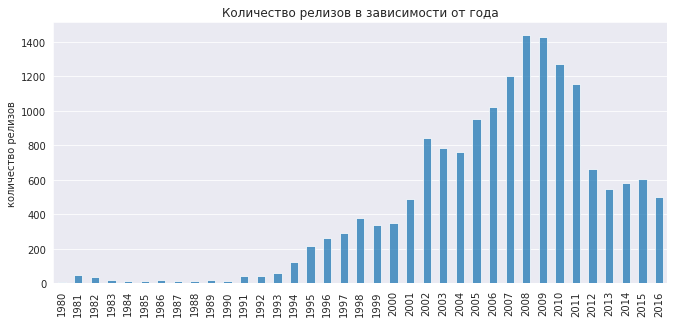

In [22]:
year_group = data.groupby('year_of_release')['year_of_release'].count()
# Уберем у названий годов дробную часть, изменив тип данных на int
year_group.index = year_group.index.astype(int)
year_group.plot(kind='bar', alpha=0.75, figsize=(11, 4.8))
plt.title('Количество релизов в зависимости от года')
plt.grid(axis='x')
plt.xlabel('')
plt.ylabel('количество релизов')
plt.show()

**Вывод:** видим, что с 1994 года начался бурный рост рынка видеоигр, тогда суммарное количество релизов удвоилось, по сравнению с 1993 годом. В 1995 году количество релизов так же почти удвоилось по сравнению с предыдущим годом, в этот период на рынок вышла PlayStation первого поколения. В 2002 году, относительно 2001 так же случилось практически двукратное увеличение количество новых игр, в этот момент появился Xbox первого поколения и активно набирала популярность PS2.<br>
Отметку в 1000 новых релизов за год рынок преодолел в 2006 году, достигнув пика по данному показателю в 2008-2009 годах. Затем данный показатель начал сокращаться. Скорее всего это связано с увеличением качества и масштабности проектов, что растягивает производственный цикл; бурным развитием мобильных устройств и соцсетей, что забрало на себя часть аудитории геймеров.

### Распределение по платформам и годам

Для начала взглянем на какие платформы вышло больше всего игр.

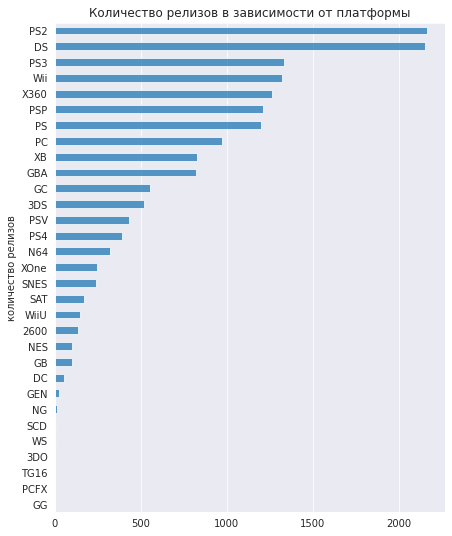

In [23]:
(
    data
    .groupby('platform')['platform']
    .count().sort_values()
    .plot(kind='barh', alpha=0.75, figsize=(7, 9))
)
plt.title('Количество релизов в зависимости от платформы')
plt.grid(axis='y')
plt.xlabel('')
plt.ylabel('количество релизов')
plt.show()

In [24]:
print('Топ-10 наиболее популярных платформ по количеству релизов:')
data.groupby('platform')['platform'].count().sort_values(ascending=False).head(10)

Топ-10 наиболее популярных платформ по количеству релизов:


platform
PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
Name: platform, dtype: int64

**Вывод:** с большим отрывом от конкурентов по количеству выпущенных игр лидируют две платформы: **PlayStation 2** и **Nintendo DS** (более чем 2100 релизов на каждую). Тройку лидеров замыкает **PlayStation 3** (около 1300 игр). **ПК**, как платформа для игр, занимает только 8 строчку (менее 1000 релизов).

Взглянем на сводную информацию о том, в какие года какие платформы были актуальны.

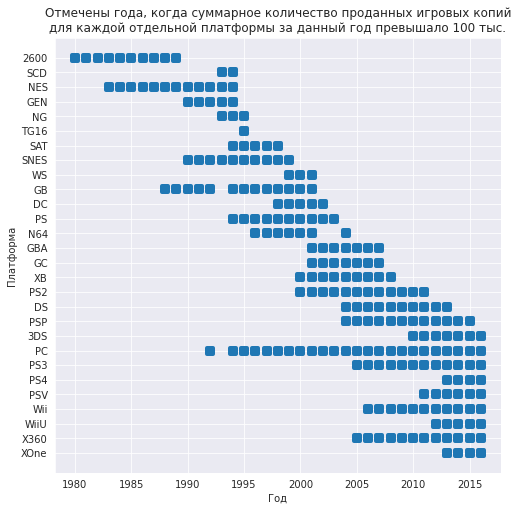

In [25]:
sales_sum = (
    data
    .pivot_table(index=['year_of_release', 'platform'], aggfunc={'total_sales': 'sum'})
    .reset_index()
    .sort_values(by='year_of_release', ascending=False)
)

# Оставим только те платформы где за год суммарные продажи игр превышают 100 тыс. копий
sales_sum_100k = sales_sum.query('total_sales > 0.1')

plt.figure(figsize=(8,8))
plt.scatter(sales_sum_100k['year_of_release'], sales_sum_100k['platform'], marker="s", linewidths=4)
plt.title('Отмечены года, когда суммарное количество проданных игровых копий\nдля каждой отдельной платформы за данный год превышало 100 тыс.')
plt.xlabel('Год')
plt.ylabel('Платформа')
plt.show()

In [26]:
# формируем список актуальных игровых платформ
actual_platforms = sales_sum.query('year_of_release == 2016')['platform'].tolist()
actual_platforms

['XOne', 'X360', 'WiiU', 'Wii', 'PSV', 'PS4', 'PS3', 'PC', '3DS']

In [27]:
# Оцениваем срок жизни ныне не актуальных платформ
(
    sales_sum
    .query('platform not in @actual_platforms')
    .pivot_table(index='platform', aggfunc={'year_of_release': 'count'})
    .describe()
)

,year_of_release
count,22.000000
mean,7.000000
std,4.070802
min,1.000000
25%,3.250000
50%,7.500000
75%,10.000000
max,13.000000


**Вывод:** как мы видим на графике, многие платформы устарели и потеряли актуальность.<br>
На 2016 год разработчиками поддерживаются **9** платформ: **XOne, X360, WiiU, Wii, PSV, PS4, PS3, PC, 3DS**.<br>
Самой долгоживущей и ныне актуальной платформой для игр являются персональные компьютеры.<br>
Средний период жизни **ныне не актуальных** платформ составляет около **7 лет**.

Рассмотрим, какие из актуальных платформ самые популярные по продажам игр на них

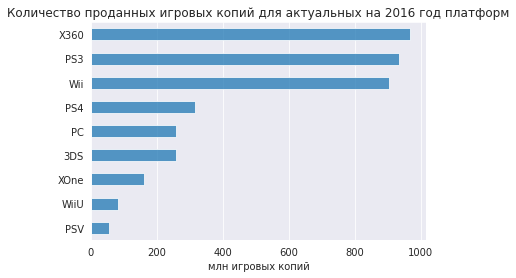

,total_sales
platform,
X360,966.67
PS3,934.71
Wii,903.31
PS4,314.14
PC,258.86
3DS,258.51
XOne,159.32
WiiU,82.19
PSV,53.81


In [28]:
(
    sales_sum
    .query('platform in @actual_platforms')
    .pivot_table(index='platform', aggfunc={'total_sales': 'sum'})
    .sort_values(by='total_sales')
    .plot(kind='barh', alpha=0.75, legend=False)
)
plt.title('Количество проданных игровых копий для актуальных на 2016 год платформ')
plt.grid(axis='y')
plt.xlabel('млн игровых копий')
plt.ylabel('')
plt.show()

sales_sum.query('platform in @actual_platforms').pivot_table(index='platform', aggfunc={'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False)

**Вывод:** с большим отрывом по продажам лидируют представители седьмого поколения игровых систем: **XBOX 360** и **PlayStation 3**, на каждую из этих консолей продано почти по миллиарду игровых копий. От лидеров примерно с трехкратным отрывом отстает консоль следующего поколения **PlayStation 4**. Далее следует платформа **ПК**, что очень удивительно, ведь судя по нашей сводке, игры для ПК выходят с 1985 года, а PS4 появилась только в 2013 году. Получается на одну консоль за 3 с небольшим года продано игр больше, чем на ПК за 31 год (на момент 2016 года).

### Тенденции игровых продаж для поддерживающихся разработчиками игровых платформ за последние 10 лет

In [29]:
data_10years = data.query('platform in @actual_platforms and year_of_release > 2006')

data_10years = data_10years.pivot_table(index='year_of_release', columns='platform', aggfunc={'total_sales': 'sum'})
data_10years.columns = data_10years.columns.droplevel()
data_10years.index = data_10years.index.astype(int)

data_10years.style.background_gradient('Blues').highlight_null('white')

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2007,nan,9.280000,73.190000,nan,nan,153.410000,nan,95.420000,nan
2008,nan,12.460000,118.790000,nan,nan,177.680000,nan,136.070000,nan
2009,nan,17.050000,130.930000,nan,nan,206.970000,nan,120.820000,nan
2010,0.300000,26.150000,142.960000,nan,nan,128.670000,nan,170.550000,nan
2011,63.200000,35.160000,157.980000,nan,4.630000,59.790000,nan,145.280000,nan
2012,51.760000,23.450000,108.280000,nan,16.190000,22.940000,17.560000,100.720000,nan
2013,56.570000,13.010000,113.250000,25.990000,10.590000,8.590000,21.650000,88.580000,18.960000
2014,43.760000,13.280000,47.760000,100.000000,11.900000,3.750000,22.030000,34.740000,54.070000
2015,27.780000,8.520000,16.820000,118.900000,6.250000,1.140000,16.350000,11.960000,60.140000


По 2016 году данные, неполные. Так как статистика собрана в конце этого же года, и не все продажи учтены.

**Вывод:** жизненный цикл некогда очень популярных консолей **PS3** и **Xbox360** подходит к концу, в виду устаревания железа. Видно, что продажи игр для них сильно сократились к 2015-2016 годам. Они уступили место своим продолжателям: **PS4** и **Xbox One**.<br>
Консоль **Nintendo Wii** уступила место актуальной наследнице **Nintendo Wii U**.<br>
Портативные консоли **Nintendo 3DS** и **PlayStation Vita** на момент 2016 года еще поддерживаются и являются актуальными. Хотя и наблюдается динамика к снижению производства игр под них.<br>
**ПК** это вечная классика, жили и будут жить. Хотя продажи игр для них уступают консолям.

**Для дальнейшего исследования будет помехой брать в расчет уже не актуальную информацию за старые года. Поэтому будем рассматривать только 3 последних года, из которых есть полные данные за 2014 и 2015 года, а так же частичная информация за 2016.**

### Тенденции игровых продаж за актуальный период (последние 3 года)

In [30]:
data_actual = data.query('platform in @actual_platforms and year_of_release > 2013')
data_actual = data_actual.copy()

data_actual_pivot = data_actual.pivot_table(index='year_of_release', columns='platform', aggfunc={'total_sales': 'sum'})
data_actual_pivot.columns = data_actual_pivot.columns.droplevel()
data_actual_pivot.index = data_actual_pivot.index.astype(int)

data_actual_pivot.style.background_gradient('Blues')

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2014,43.760000,13.280000,47.760000,100.000000,11.900000,3.750000,22.030000,34.740000,54.070000
2015,27.780000,8.520000,16.820000,118.900000,6.250000,1.140000,16.350000,11.960000,60.140000
2016,15.140000,5.250000,3.600000,69.250000,4.250000,0.180000,4.600000,1.520000,26.150000


Итого, наиболее перспективными и прибыльными платформами являются два вечных соперника **PS4** и **Xbox One**. На 2016 год это свежие консоли, лучшие игры под которые еще не увидели свет. Так же довольно перспективными являются два товарища от Nintendo - это **Wii U** и **3DS**, хотя последняя уже довольно устаревшая, но все же, почти 28 млн. проданных игр за 2015 год - это внушительно. Особняком стоит **ПК**, с одной стороны продажи игр сильно уступают консолям, но с другой стороны платформа имеет совершенно отличную от консолей философию и подразумевает апгрейд железа, что не позволит ей устареть до появления устройств принципиально иного типа, которые когда нибудь заменят персональные компьютеры. 

Рассмотрим эти 5 самых перспективных платформ более подробно.

platform,PS4,XOne,WiiU,3DS,PC
year_of_release,,,,,
2014,100.000000,54.070000,22.030000,43.760000,13.280000
2015,118.900000,60.140000,16.350000,27.780000,8.520000
2016,69.250000,26.150000,4.600000,15.140000,5.250000


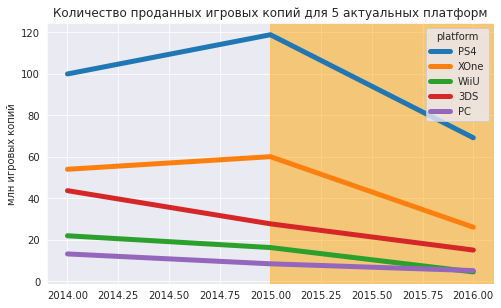

In [31]:
data_actual_pivot_top5 = data_actual_pivot.loc[:, ['PS4', 'XOne', 'WiiU', '3DS', 'PC']]
display(data_actual_pivot_top5.style.background_gradient('Blues'))

data_actual_pivot_top5.plot(linewidth=5, figsize=(8, 4.8)).add_patch(mpl.patches.Rectangle((2015, -10), 2, 140, alpha=0.5, color='orange'))
plt.title('Количество проданных игровых копий для 5 актуальных платформ')
plt.xlabel('')
plt.ylabel('млн игровых копий')
plt.show()

**Вывод:** оранжевой заливкой справа закрашен 2016 год, данные за который неполные, к ним нужно относиться с осторожностью. На графике наглядно видно текущее доминирование **PlayStation 4** над остальными платформами. **Xbox One** хоть и отстает в два раза от лидера, но все же, является второй по популярности консолью. Так же эти две платформы показали увеличение продаж с 2014 по 2015 год. Консоли от **Nintendo** в последние годы демонстрируют тенденцию к снижению интереса к себе со стороны пользователей. Игры для **ПК** так же стали продаваться немного хуже.

### Глобальные продажи игр в по платформам

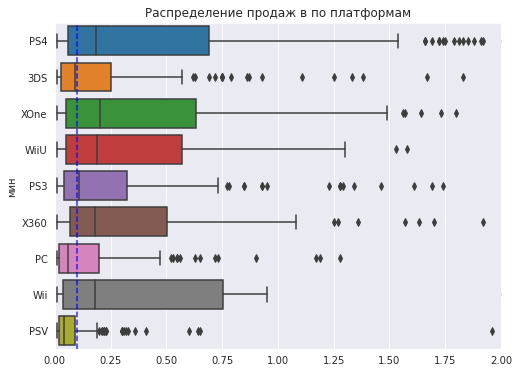

Медиана количества продаж по всем актуальным платформам (млн) - синяя линия: 0.09999999999999999 

Медиана количества продаж для каждой отдельной платформы (млн):
 platform
XOne    0.205
WiiU    0.190
PS4     0.185
Wii     0.180
X360    0.180
PS3     0.110
3DS     0.090
PC      0.060
PSV     0.040
Name: total_sales, dtype: float64


In [32]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data_actual, x='total_sales', y='platform')
plt.xlim(0, 2)
plt.axvline(x = data_actual['total_sales'].median() ,linestyle='dashed', color='blue', alpha=.8)
plt.title('Распределение продаж в по платформам')
plt.ylabel('мин')
plt.xlabel('')
plt.show()

print('Медиана количества продаж по всем актуальным платформам (млн) - синяя линия:', data_actual['total_sales'].median(), '\n')
print('Медиана количества продаж для каждой отдельной платформы (млн):\n', data_actual.groupby('platform')['total_sales'].median().sort_values(ascending=False))

**Вывод:** если рассматривать медианное количество продаж, то лидером являются **Xbox One** с показателем 205 тыс. копий; хоть общее количество продаж игр для этой платформы почти вдвое уступает PS4, но каждая отдельно взятая игра расходится немного бóльшими тиражами.  Далее следуют **WiiU** и **PS4**. Игры для старых консолей **PS3** и **Xbox 360** все еще неплохо продаются, но это происходит по инерции, благодаря огромной популярности в прошлом. **ПК** здесь в аутсайдерах, наравне с теряющей актуальность портативкой **PSVita**.

Отдельно рассмотрим распределение хитов среди релизов по платформам. За "хит" условно примем проект, преодолевший порог 2 млн продаж для отдельной платформы

In [33]:
display(
    data_actual.query('total_sales >= 2')
    .pivot_table(index='platform', aggfunc={'total_sales': ['sum', 'count', 'max']})
    .sort_values(by=('total_sales', 'count'), ascending=False)
)

data_actual.sort_values(by='total_sales', ascending=False).head()

total_sales               
               count    max     sum
platform                           
PS4               39  14.63  176.21
XOne              20   7.39   69.26
3DS               10  11.68   47.22
PS3                4   5.27   16.61
WiiU               4   7.09   19.61
X360               3   4.28    9.25
PC                 1   3.05    3.05
Wii                1   2.01    2.01

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,None,14.63
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,83.0,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,None,11.68
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,43.0,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,None,7.98


**Вывод:** как можно заметить, за последние годы подавляющее большинство успешных проектов вышли на новых консолях **PS4** и **Xbox One**.

### Влияние отзывов пользователей и критиков на продажи в рамках одной платформы

Возьмем две популярных и перспективных платформы - **PlayStation 4** и **Xbox One** и рассмотрим, как оценки критиков и пользователей влияют на успешность продаж.

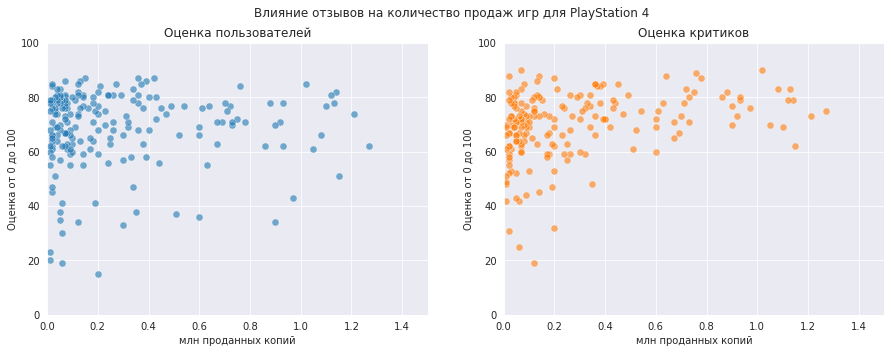

Корреляция между продажами игр на PlayStation 4 и отзывами пользователей: -0.04013158947269736
Корреляция между продажами игр на PlayStation 4 и отзывами критиков: 0.40266141068104083


In [34]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Влияние отзывов на количество продаж игр для PlayStation 4')
plt.subplot(1, 2, 1)
sns.scatterplot(data=data_actual.query('platform == "PS4"'), x='total_sales', y='user_score', alpha=.6, s=50)
#plt.legend(labels = ['Оценка пользователей'])
plt.xlim(0, 1.5)
plt.ylim(0, 100)
plt.title('Оценка пользователей')
plt.xlabel('млн проданных копий')
plt.ylabel('Оценка от 0 до 100')


plt.subplot(1, 2, 2)
sns.scatterplot(data=data_actual.query('platform == "PS4"'), x='total_sales', y='critic_score', alpha=.6, s=50, color='C1')
#plt.legend(labels = ['Оценка критиков'])
plt.xlim(0, 1.5)
plt.ylim(0, 100)
plt.title('Оценка критиков')
plt.xlabel('млн проданных копий')
plt.ylabel('Оценка от 0 до 100')
plt.show()


print('Корреляция между продажами игр на PlayStation 4 и отзывами пользователей:', data_actual.query('platform == "PS4"')['total_sales'].corr(data_actual.query('platform == "PS4"')['user_score']))
print('Корреляция между продажами игр на PlayStation 4 и отзывами критиков:', data_actual.query('platform == "PS4"')['total_sales'].corr(data_actual.query('platform == "PS4"')['critic_score']))

**Вывод:** корреляция между оценкой критиков и количеством продаж довольно неплохо прослеживается. Тогда как пользовательские оценки распределены более хаотично, а коэффициент корреляции близок к нулю.

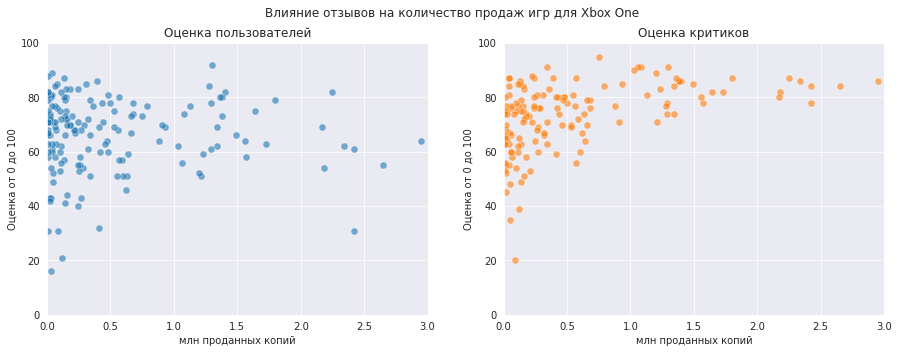

Корреляция между продажами игр на Xbox One и отзывами пользователей: -0.07038392806475827
Корреляция между продажами игр на Xbox One и отзывами критиков: 0.42867694370333226


In [35]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Влияние отзывов на количество продаж игр для Xbox One')
plt.subplot(1, 2, 1)
sns.scatterplot(data=data_actual.query('platform == "XOne"'), x='total_sales', y='user_score', alpha=.6, s=50)
#plt.legend(labels = ['Оценка пользователей'])
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.title('Оценка пользователей')
plt.xlabel('млн проданных копий')
plt.ylabel('Оценка от 0 до 100')


plt.subplot(1, 2, 2)
sns.scatterplot(data=data_actual.query('platform == "XOne"'), x='total_sales', y='critic_score', alpha=.6, s=50, color='C1')
#plt.legend(labels = ['Оценка критиков'])
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.title('Оценка критиков')
plt.xlabel('млн проданных копий')
plt.ylabel('Оценка от 0 до 100')
plt.show()


print('Корреляция между продажами игр на Xbox One и отзывами пользователей:', data_actual.query('platform == "XOne"')['total_sales'].corr(data_actual.query('platform == "XOne"')['user_score']))
print('Корреляция между продажами игр на Xbox One и отзывами критиков:', data_actual.query('platform == "XOne"')['total_sales'].corr(data_actual.query('platform == "XOne"')['critic_score']))

**Вывод:** ситуация схожая с PlayStation 4 - оценки критиков оказывают влияние на продажи, а пользовательские оценки - нет.

Теперь рассмотри сразу все актуальные платформы.

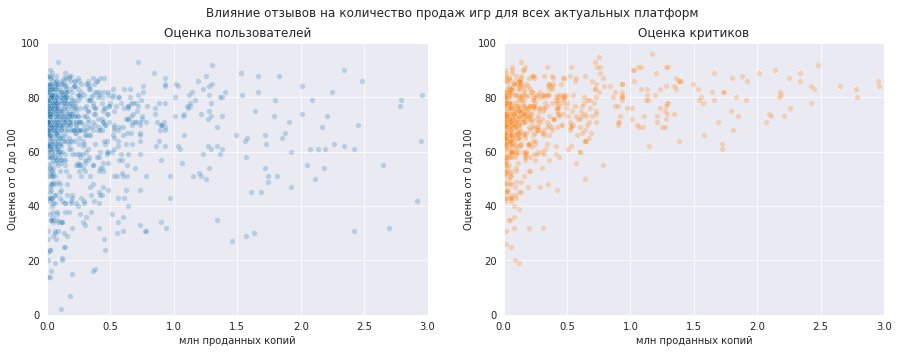

Корреляция между продажами игр и отзывами пользователей: -0.013070305002484541
Корреляция между продажами игр и отзывами критиков: 0.328105086966363


In [36]:
plt.subplots(figsize=(15, 5))
plt.suptitle('Влияние отзывов на количество продаж игр для всех актуальных платформ')
plt.subplot(1, 2, 1)
sns.scatterplot(data=data_actual, x='total_sales', y='user_score', alpha=.25, s=30)
#plt.legend(labels = ['Оценка пользователей'])
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.title('Оценка пользователей')
plt.xlabel('млн проданных копий')
plt.ylabel('Оценка от 0 до 100')


plt.subplot(1, 2, 2)
sns.scatterplot(data=data_actual, x='total_sales', y='critic_score', alpha=.25, s=30, color='C1')
#plt.legend(labels = ['Оценка критиков'])
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.title('Оценка критиков')
plt.xlabel('млн проданных копий')
plt.ylabel('Оценка от 0 до 100')
plt.show()


print('Корреляция между продажами игр и отзывами пользователей:', data_actual['total_sales'].corr(data_actual['user_score']))
print('Корреляция между продажами игр и отзывами критиков:', data_actual['total_sales'].corr(data_actual['critic_score']))

**Вывод:** если брать в расчет данные сразу по всем актуальным платформам (**XOne, X360, WiiU, Wii, PSV, PS4, PS3, PC, 3DS**), то ситуация с пользовательскими оценками сохранилась - корреляция близка к нулю. Но, в свою очередь, зависимость между продажами и оценками критиков немного снизилась. По всей видимости, критики ставящие оценки для игр PlayStation 4 и Xbox One оказывают большее влияние на продажи, чем все критики вместе взятые на бóльшую часть игровой индустрии.

### Прибыльность различных жанров

Для начала рассмотрим, распределение жанров по количеству игр

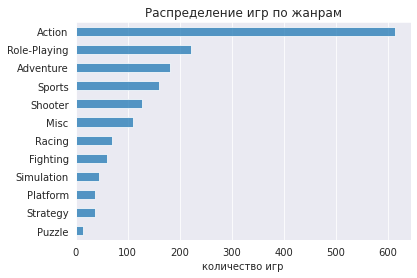

In [37]:
(
    data_actual
    .pivot_table(index='genre', aggfunc={'name': 'count'})
    .sort_values(by='name')
    .plot(kind='barh', alpha=0.75, legend=False)
)
plt.title('Распределение игр по жанрам')
plt.grid(axis='y')
plt.xlabel('количество игр')
plt.ylabel('')
plt.show()

**Вывод:** самым популярным жанром по количеству выпущенных игр является **action**, далее идет **role-playing** и **adventure**. Самым редко встречающимся жанров является - **puzzle**.

Если мы возьмем суммарные продажи по жанрам, то вид распределения не сильно поменяется. Поэтому рассмотрим медианные продажи по каждому жанру.

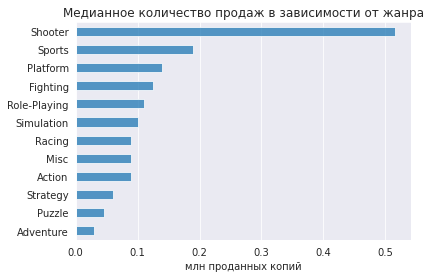

In [38]:
(
    data_actual
    .pivot_table(index='genre', aggfunc={'total_sales': 'median'})
    .sort_values(by='total_sales')
    .plot(kind='barh', alpha=0.75, legend=False)
)
plt.title('Медианное количество продаж в зависимости от жанра')
plt.grid(axis='y')
plt.xlabel('млн проданных копий')
plt.ylabel('')
plt.show()

**Вывод:** здесь расклад поменялся. **шутер** - не самый распространенный жанр, но медианное число продаж у него самое высокое, более чем в 2.5 раза большее чем у ближайшего конкурента. Это вызвано тем, больше количество масштабных блокбастеров выходят как раз в этом жанре. Далее идут **спортивные игры** и **платформеры**.<br>
Самыми неохотно продающимися жанрами являются **стратегии**, **головоломки** и **квесты**.

## Портрет пользователя каждого региона

In [39]:
# Заполняем пропуски в столбце 'rating' строковым значением 'None'
# для отображения этих данных на диаграммах
data_actual['rating'].fillna(value='None', inplace=True)

In [40]:
# Составляем словарь для понятных подписей диаграмм
# Порядок элементов словаря влияет на порядок отрисовки диаграмм
regions_name = {
    'eu_sales': 'Европа', 
    'na_sales': 'Северная\nАмерика',
    'jp_sales': 'Япония'
}

# Функция для отрисовки круговых диаграмм
def pie_regions(group, title, top=True):
    # Формируем табличку по указанному признаку для каждой платформы в каждом регионе
    data_actual_group = data_actual.pivot_table(index=group, aggfunc={'eu_sales': 'sum', 'jp_sales': 'sum', 'na_sales': 'sum',})

    # Формируем список цветов для того, что бы цветовая схема совпадала на разных диаграммах
    colours = pd.Series(range(len(data_actual_group)), index=data_actual_group.index)
    colours = colours.append(pd.Series(len(colours), index=['other']))

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(title)
    for ax, col in zip(axes, regions_name.keys()):
        # Формируем series для каждого региона
        top5 = data_actual_group[col].sort_values(ascending=False)
        if top:
            # Элементы не входящие в топ-5 суммируются между собой
            top5 = pd.concat([top5[:5], pd.Series(top5[5:].sum(), index=['other'])])
        ax.pie(
            x=top5, 
            labels=top5.index, 
            autopct='%.1f%%', 
            startangle = 90, 
            pctdistance=.8, 
            wedgeprops={'width': .4}, 
            colors=[plt.cm.tab20.colors[colours.loc[key]] for key in top5.index]
        )
        ax.set(title='', xlabel='', ylabel='')
        ax.text(0,0, regions_name.get(col), horizontalalignment='center', verticalalignment='center', fontweight='bold')
    
    plt.show()

### Самые популярные платформы (топ-5)

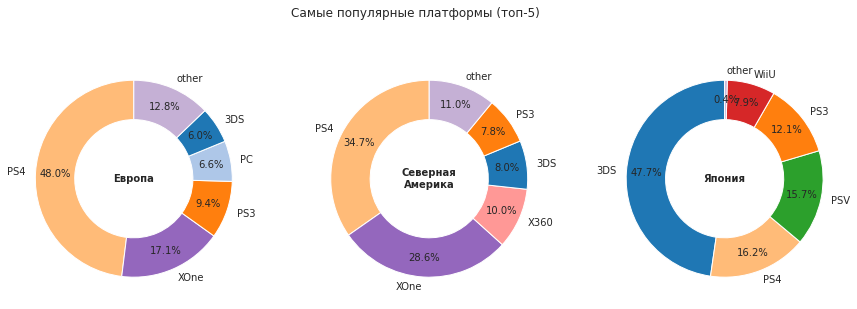

In [41]:
pie_regions('platform', 'Самые популярные платформы (топ-5)')

**Вывод:** в Европе самой популярной игровой платформой является **PlayStation 4**, практически каждая вторая проданная игра приходится именно на неё. Второе место с 17% продаж занимает **Xbox One**.<br>
В Северной Америке лидеры те же, но **PlayStation 4** забирает на себя 34.7% продаж, а **Xbox One** 28.6%. Что интересно, в Европе и Америке общая доля продаж, приходящаяся в сумме на эти две консоли вместе взятые, примерно одинаковая, в районе 63-65%. <br>
Рынок Японии довольно сильно отличается от остальных регионов, здесь почти половину рынка занимает **Nintendo 3DS**. А в сумме 63.4% всех продаж видеоигр приходится на портативные консоли (3DS и PSVita). **PlayStation 4** здесь занимает 16.2%, а **Xbox One** вовсе практически не встречается.<br>
Игры для **ПК** входят в топ-5 только в Европе, в остальных регионах представлены реже.

### Самые популярные жанры (топ-5)

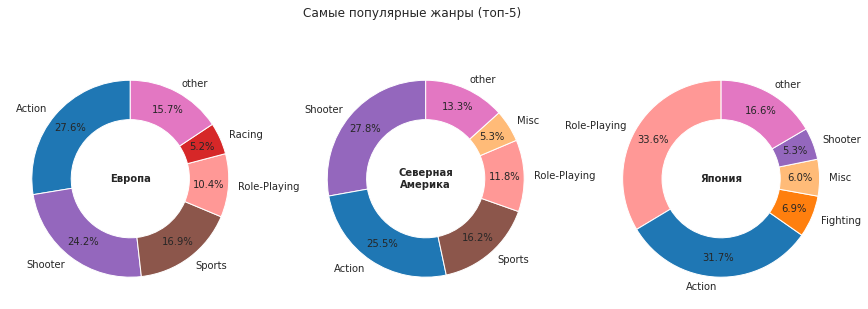

In [42]:
pie_regions('genre', 'Самые популярные жанры (топ-5)')

**Вывод:** предпочтения пользователей из Европы и Америки в целом похожи. В Европе лидером является жанр **action**, затем идет **shooter**, а Америке - наоборот. Первые 4 позиции в топе одинаковые.<br>
Японский пользователь отличается от геймеров из других регионов - здесь самым популярным жанром является **role-playing**, второе место занимает **action**.  А жанр **shooter**, занимающий лидирующие места по популярности в других регионах, здесь находится только на 5 месте.

### Влияние возрастного рейтинга ESRB на количество продаж

- `EC` («Early childhood») — Для детей младшего возраста
- `E` («Everyone») — Для всех
- `E10+` («Everyone 10 and older») — Для всех от 10 лет и старше
- `T` («Teen») — Подросткам (для лиц от 13 лет)
- `M` («Mature») — Для взрослых (для лиц от 17 лет)
- `AO` («Adults Only 18+») — Только для взрослых (для лиц от 18 лет)

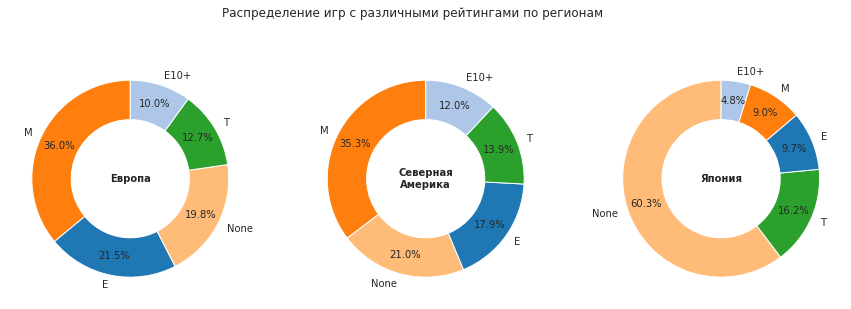

In [43]:
pie_regions('rating', 'Распределение игр с различными рейтингами по регионам', top=False)

**Вывод:** для начала заметим, что рейтинг `AO` вообще не встречается в нашей выборке, по всей видимости его присваивают в исключительных случаях.<br>
Ситуация вырисовывается следующая - Европа и Северная Америка здесь вновь практически одинаковы - наибольшие продажи у игр с рейтингом `M` (для лиц от 17 лет). Там взрослый рейтинг не отпугивает, а наоборот, притягивает игроков. А доля игр без рейтинга составляет примерно 20-21%.<br>
В Японии же 60% продаж приходится на игры без возрастного рейтинга ESRB. Могу предположить, что из-за общей специфичности японского рынка там выходит большое количество локальных релизов, не представленных массово в других регионах, поэтому такие релизы не попадают на сертификацию к американской организации ESRB. В Японии существуют собственные организации, занимающиеся присвоением возрастных рейтингов для игр, такие как CERO и EOCS. С рейтингом `M` от ESRB, который в других регионах лидирует по продажам, в Японии продается только каждая одиннадцатая игра.

Не стоит забывать, что отсутсвие рейтинга не говорит о том, что игра не проходила сертификацию ESRB. Отсутсвие данного показателя может быть вызвано ошибкой при выгрузке данных или банальным чловеческим фактором.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

*Проверка гипотезы:* средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**H0:** средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**.<br>
**H1:** средние пользовательские рейтинги платформ Xbox One и PC **разные**.

In [44]:
user_score_xone = data_actual.query('platform == "XOne" and not user_score.isna()')['user_score']
user_score_pc = data_actual.query('platform == "PC" and not user_score.isna()')['user_score']
hypothesis_1 = st.ttest_ind(user_score_xone, user_score_pc)

print('p-value:', hypothesis_1.pvalue)

if hypothesis_1.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

print(f'\nСредний пользовательский рейтинг игр Xbox One на выборке из {user_score_xone.count()} оценок:', user_score_xone.mean().round(2))
print(f'Средний пользовательский рейтинг игр PC на выборке из {user_score_pc.count()} оценок:', user_score_pc.mean().round(2))

p-value: 0.10450507919348478
Нет оснований отвергнуть нулевую гипотезу

Средний пользовательский рейтинг игр Xbox One на выборке из 165 оценок: 65.95
Средний пользовательский рейтинг игр PC на выборке из 122 оценок: 62.98


**Вывод:** нулевая гипотеза о равенстве средних пользовательских оценок для платформ Xbox One и PC не отвергается. Есть основания утверждать, что средние пользовательские рейтинги на этих платформах совпадают.

### Средние пользовательские рейтинги жанров Action и Sports разные

*Проверка гипотезы:* средние пользовательские рейтинги жанров Action и Sports разные.

**H0:** средние пользовательские рейтинги жанров Action и Sports **одинаковые**.<br>
**H1:** средние пользовательские рейтинги жанров Action и Sports **разные**.

In [45]:
user_score_action = data_actual.query('genre == "Action" and not user_score.isna()')['user_score']
user_score_sports = data_actual.query('genre == "Sports" and not user_score.isna()')['user_score']
hypothesis_1 = st.ttest_ind(user_score_action, user_score_sports)

print('p-value:', hypothesis_1.pvalue)

if hypothesis_1.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

print(f'\nСредний пользовательский рейтинг жанра Action на выборке из {user_score_action.count()} оценок:', user_score_action.mean().round(2))
print(f'Средний пользовательский рейтинг жанра Sports на выборке из {user_score_sports.count()} оценок:', user_score_sports.mean().round(2))

p-value: 2.871114798510669e-19
Отвергаем нулевую гипотезу

Средний пользовательский рейтинг жанра Action на выборке из 297 оценок: 67.61
Средний пользовательский рейтинг жанра Sports на выборке из 127 оценок: 52.25


**Вывод:** нулевая гипотеза о равенстве средних пользовательских рейтингов у жанров Action и Sports отвергается. Есть основания утверждать, что средние пользовательские рейтинги у данных жанров отличаются.

### Ответы на вопросы

***В:** Как вы сформулировали нулевую и альтернативную гипотезы?*<br>
**О:** В обоих случаях мы использовали двустороннюю гипотезу о равенстве средних двух генеральных совокупностей.<br>
В этом случае нулевая и альтернативная гипотезы формулируются по следующему паттерну:
- **H0:** среднее значение первой генеральной совокупности **равно** среднему значению второй генеральной совокупности.
- **H1:** среднее значение первой генеральной совокупности **не равно** среднему значению второй генеральной совокупности.


<br>***В:** Какой критерий применили для проверки гипотез и почему?*<br>
**О:** Для проверки гипотез параметр `p-value` (вероятность при верной нулевой гипотезе получить наблюдаемое значение или более удалённое от того, которое мы предположили в H0) сравнивается с `alpha` *уровнем статистической значимости* (порог, выраженный в процентах, при котором отклонение можно считать значимым, а не случайным).<br>
Такое сравнение позволяет либо отвергнуть H0 в пользу H1, либо не отвергнуть.

## Общий вывод

**В рамках проведения исследования было выполнено:**
1. Произведена предобработка данных, а именно: удалены пропуски (где это было возможно) и дубликаты.
2. Проанализированы ключевые параметры, построены графики.
3. Выделены актуальные игровые платформы; а среди актуальных наиболее перспективные.
4. Определено влияние оценок пользователей и критиков на продажи.
5. Определены наиболее популярные и прибыльные жанры.
6. Произведено сравнение портретов пользователей из различных регионов, определены сходства и основные различия.
7. Проверены статистические гипотезы.

**Краткие выводы, резюмирующие проведенное исследование и отражающие его основные результаты:**
1. С **1994-1995** годов начался бурный рост отросли видеоигр. По количеству выпускаемых игр в год пик наблюдался в **2008-2009**, далее этот показатель начал постепенно снижаться.
2. По количеству выпущенных игр лидируют две платформы: **PlayStation 2** и **Nintendo DS** (более чем 2100 релизов на каждую). Тройку лидеров замыкает **PlayStation 3** (около 1300 игр).
3. На 2016 год продолжают появляться новые игры для 9 платформ: **XOne, X360, WiiU, Wii, PSV, PS4, PS3, PC, 3DS**.
4. Средний период жизни **ныне не актуальных** платформ составляет около **7 лет**.
5. По продажам игр лидируют: **XBOX 360** и **PlayStation 3**, на каждую из этих консолей продано почти по миллиарду игровых копий.
6. Наиболее перспективными в плане потенциального роста являются **PlayStation 4** и **Xbox One**.
7. По медианному количеству продаж лидером являются **Xbox One**, далее следуют **WiiU** и **PS4**.
8. **Оценки критиков** могут оказывать небольшое или даже среднее влияние на количество продаж. **Оценки пользователей**, как правило, на продажи не влияют.
9. Самым распространенным жанром является **Action**. А наибольшие медианные продажи имеет жанр **Shooter**.
10. Поведение пользователей **Европы** и **Северной Америки** во многом схожи. **Японский пользователь** от них отличается - значительно большим интересом к портативным консолям; национальной любовью к Nintendo; относительным равнодушием к популярному в других регионах жанру **Shooter**.
11. В **Европе** и **Северной Америке** преобладают игры с рейтингом `M` (для лиц от 17 лет). В Японии подавляющее большинство игр выходят без сертификации ESRB.
12. Есть основания утверждать, что средние пользовательские рейтинги на платформах **Xbox One** и **PC** совпадают.
13. Есть основания утверждать, что средние пользовательские рейтинги у жанров **Action** и **Sports** отличаются.

<br><br>*Итого, перечислим некоторые конкретные рекомендации для максимизации вероятности успеха потенциального продукта:*
- **Выбор платформы**:
    1. Если делается ставка на эксклюзивный продукт для одной платформы, то лучшим претендентом будет **PlayStation 4**. На данную консоль во всех регионах, и кроме Японии, продается больше всего игр.
    2. Если продукт планируется выпускать на нескольких платформах, то к **PlayStation 4** определенно стоит добавить версию для **Xbox One**. Две данные консоли вместе взятые в Европе и Северной Америке забирают на себя более 63% всех продаж видеоигр. Но консоль от microsoft практически не представлена в Японии. Хороший плюс платформы **Xbox One**, это самый высокий показатель медианных продаж. Скорее всего это связано с меньшей конкуренцией, чем на более популярной PlayStation 4.
    3. Если делается ставка на японский рынок или же на игры для портативных консолей в целом, то определенно стоит обратить внимание на платформу **Nintendo 3DS**. В Японии она занимает практически половину рынка продаж всех видеоигр. К тому же разработка игр под портативную консоль обойдется дешевле, чем под стационарную. Данная платформа, если ее сравнивать со всеми другими игровыми системами, не пользуется большим спросом в Европе и Америке, но все же входит в топ-5, и забирает на себя примерно 6-8% всех продаж. Но среди именно портативных консолей она будет лучшим выбором для всех регионов. Минусом данного выбора является то, что у данной платформы наблюдается тенденция к сокращению продаж. Это не позволит планировать сложный и долгий в разработке проект под нее.
<br><br>
- **Выбор жанра**:
    1. **Shooter** один из наиболее успешных жанров. По количеству всех продаж он занимает примерно четверть всего объема рынка в Европе и  Северной Америке. Его огромным плюсом также является то, что его медианные продажи превышают продажи ближайших конкурентов в 2.5 раза. Единственное, что на японском рынке он менее популярен, чем в других регионах, занимая всего около 5% рынка.
    2. **Action** так же является отличным выбором. Медианные продажи ниже, чем у шутеров, но зато сам по себе жанр так же популярен в Европе и Америке, плюс в Японии примерно каждая третья игра выходит именно в жанре экшен.
<br><br>
- **Выбор возрастного рейтинга ESRB**: в Европе и Северной Америке наибольшие продажи у игр со взрослым рейтингом `M` (для лиц от 17 лет). В Японии с данным рейтингом продается только 9% игр. Так же хорошим универсальным решением является выбор рейтинга `E` (Для всех), с данным рейтингом в Европе и Америке продается примерно 18-21% игр, а в Японии 10%.
<br><br>
- **Оценки критиков**: так же не помешает учитывать тот факт, что оценки критиков оказывают некоторое влияние на успешность продаж. И для максимизации продаж необходимо, что бы оценки эти были в больше степени положительные.